Character Embedding on Patent Data
=============

Converting assignment 5 of Udacity's Deep Learning course to apply character embedding to a sample of patent text.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
# from sklearn.manifold import TSNE
import logging
import pickle

from patentdata.corpus import USPublications
# Probably need to move the patentcorpus.py file into the main patentdata directory
from patentdata.models.patentcorpus import LazyPatentCorpus, CorpusSentenceIterator

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Get a sample of the patent publications in area G06.(Maybe later replace this with a set of patent grant records.)

In [68]:
# Load our list of G06 records
PIK = "G06records.data"

if os.path.isfile(PIK):
    with open(PIK, "rb") as f:
        print("Loading data")
        records = pickle.load(f)
        print("{0} records loaded".format(len(records)))
else:
    records = ds.get_records(["G", "06"])
    with open(PIK, "wb") as f:
        pickle.dump(records, f)
        
# Get data from 100 random descriptions across the data
records_random_sample = random.sample(records, 500)
print("Random sample of {0} records".format(len(records_random_sample)))
print(records_random_sample[0:5])

path = '/media/SAMSUNG1/Patent_Downloads'
ds = USPublications(path)

Loading data
554570 records loaded
Random sample of 500 records
[(1137471, '2006/I20060518.ZIP', './I20060518/UTIL0104/US20060104495A1-20060518.ZIP'), (3818014, '2014/I20140828.tar', 'I20140828/UTIL0244/US20140244467A1-20140828.ZIP'), (1505939, '2007/I20070809.ZIP', './I20070809/UTIL0186/US20070186180A1-20070809.ZIP'), (1162429, '2006/I20060615.ZIP', './I20060615/UTIL0129/US20060129461A1-20060615.ZIP'), (3941538, '2015/I20150219.tar', 'I20150219/UTIL0049/US20150049057A1-20150219.ZIP')]


For character encodings we want raw text as big string.

In [70]:
# See if we have a saved copy of our data - if not create it (takes a while)
filename = "rawtext500.pkl"

if os.path.isfile(filename):
    with open(filename, "rb") as f:
        print("Loading data")
        rawtext = pickle.load(f)
        print("Big text loaded")
else:
    lzy = LazyPatentCorpus()
    lzy.init_by_filenames(ds, records_random_sample)
    # Extract the text of the 100 files as a big long text string
    rawtext = str()
    for pd in lzy.documents:
        rawtext += pd.text
    with open(filename, "wb") as f:
        pickle.dump(rawtext, f)

See how big the data is.

In [72]:
print('Data size %d' % len(rawtext))

Data size 29835839


Looking at previous collections of characters - it looks like the strings are encoded with unicode 16? Can we convert all characters to unicode 8 first?  

UTF-16 characters seem to be present but no UTF-32. UTF-16 has dimensionality of 65,536 possible characters (although used characters will be a lot less).

Start by UNKing everything that is not UTF-8. Then we can scale up by increasing the input dimensionality.

Build the dictionary and replace rare words with UNK token.

In [73]:
c = collections.Counter(rawtext)

In [74]:
c

Counter({'\n': 216413,
         ' ': 4705632,
         '!': 48,
         '#': 582,
         '$': 346,
         '%': 944,
         '&': 356,
         "'": 4658,
         '(': 50997,
         ')': 51585,
         '*': 1494,
         '+': 2234,
         ',': 255901,
         '-': 52532,
         '.': 232663,
         '/': 19544,
         '0': 129628,
         '1': 145535,
         '2': 92988,
         '3': 52484,
         '4': 52605,
         '5': 40947,
         '6': 38931,
         '7': 22107,
         '8': 27462,
         '9': 17523,
         ':': 10140,
         ';': 17335,
         '<': 866,
         '=': 3637,
         '>': 973,
         '?': 108,
         '@': 92,
         'A': 53147,
         'B': 17219,
         'C': 30655,
         'D': 26148,
         'E': 18977,
         'F': 46159,
         'G': 33517,
         'H': 8943,
         'I': 79199,
         'J': 2398,
         'K': 3172,
         'L': 16305,
         'M': 22219,
         'N': 15572,
         'O': 17559,
         'P

In [13]:
chr(0)

'\x00'

In [80]:
import string
string.printable[:-2]

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r'

In [82]:
string.printable.index('\r') + 1

98

In [84]:
#vocabulary_size = 50000

# I do need character conversion functions as abstracts so I can vary the mappings

# \n is 10 - so may need a dictionary
import string

def char_to_int(c):
    """ Convert a character into an integer."""
    try:
        return string.printable.index(c) + 1
    except:
        return 0
    #return ord(c) - 31

def int_to_char(d):
    """ Convert an integer index into a character."""
    if d > 0:
        return string.printable[d-1]
    else:
        return " "
    #return chr(d + 31)

def build_dataset(rawtext):
    """ Process raw text to convert to integers.
    We will start by UNK-ing anything that is not UTF-8
    """
    # There is probably a faster way to do this
    # UNK = index 0 (can experiment with replacing with space instead = 32)
    #data = [char_to_int(c) if (len(c.encode('UTF-8')) and ord(c) > 31 and ord(c) < 128) == 1 else 0 for c in rawtext]
    data = [char_to_int(c) for c in rawtext]
    count = collections.Counter([int_to_char(d) for d in data])
    return data, count

data, count = build_dataset(rawtext)
print('Most common characters (+UNK)', count.most_common())
print('Sample data', data[:10])
print('Max index: ', max(data))
#del rawtext  # Hint to reduce memory.

Most common characters (+UNK) [(' ', 4744556), ('e', 3027332), ('t', 2191602), ('a', 1828670), ('i', 1819491), ('o', 1726364), ('n', 1712860), ('r', 1548621), ('s', 1426867), ('c', 986385), ('d', 916661), ('h', 887907), ('l', 782614), ('m', 690276), ('p', 596801), ('u', 573419), ('f', 507358), ('g', 431770), ('b', 312164), ('y', 297127), (',', 255901), ('v', 244361), ('.', 232663), ('\n', 216413), ('w', 211037), ('1', 145535), ('0', 129628), ('2', 92988), ('k', 80468), ('I', 79199), ('x', 71529), ('T', 69679), ('A', 53147), ('4', 52605), ('-', 52532), ('3', 52484), (')', 51585), ('(', 50997), ('F', 46159), ('S', 41722), ('5', 40947), ('6', 38931), ('G', 33517), ('q', 32690), ('C', 30655), ('P', 29419), ('8', 27462), ('D', 26148), ('R', 24666), ('M', 22219), ('7', 22107), ('z', 19631), ('/', 19544), ('E', 18977), ('O', 17559), ('9', 17523), (';', 17335), ('B', 17219), ('L', 16305), ('j', 15967), ('N', 15572), ('U', 12182), (':', 10140), ('H', 8943), ('W', 8780), ('V', 8241), ("'", 4658)

I think we will need to do some mapping to printable characters. The first 31 characters are non-printable control characters and so will not appear. By getting rid of those we can instantly reduce the dimensionality by 32.  

We can get rid of them by subtracting 31 from the values.

In [ ]:
del rawtext

Function to generate a training batch for the skip-gram model.

In [85]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # Buffer generated from double-ended queue with fast add/remove
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [int_to_char(di) for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [int_to_char(bi) for bi in batch])
    print('    labels:', [int_to_char(li) for li in labels.reshape(8)])

data: ['A', ' ', 's', 'y', 's', 't', 'e', 'm']

with num_skips = 2 and skip_window = 1:
    batch: [' ', ' ', 's', 's', 'y', 'y', 's', 's']
    labels: ['A', 's', 'y', ' ', 's', 's', 'y', 't']

with num_skips = 4 and skip_window = 2:
    batch: ['s', 's', 's', 's', 'y', 'y', 'y', 'y']
    labels: ['s', 'A', 'y', ' ', 's', 's', ' ', 't']


Above num_skips is the number of times a single character in the dataset is repeated and skip_window is the number of characters either side that are included.

To look at 3 characters either side (i.e. skip_window = 3) we need number of skips to equal 6 and batch size to equal 12.

In [86]:
data_index = 0
batch, labels = generate_batch(batch_size=12, num_skips=6, skip_window=3)
print('\nwith num_skips = %d and skip_window = %d:' % (6, 3))
print('    batch:', [int_to_char(bi) for bi in batch])
print('    labels:', [int_to_char(li) for li in labels.reshape(12)])


with num_skips = 6 and skip_window = 3:
    batch: ['y', 'y', 'y', 'y', 'y', 'y', 's', 's', 's', 's', 's', 's']
    labels: ['s', 'e', ' ', 't', 'A', 's', 't', ' ', 'y', 'm', 's', 'e']


Two skips seems enough (which gives us 3 character n-grams).

Train a skip-gram model.

In [95]:
vocabulary_size = max(data)+1 # As computed above is 94 + 1
batch_size = 128
embedding_size = 3 # Dimension of the embedding vector.
skip_window = 1 # How many characters to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_examples = np.array(random.sample(range(vocabulary_size), valid_size))


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    # We might be able to pick a better initialisation for out embeddings matrix
    # Set the first 31 to 0, then 32 to 127
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # This is a projection of the embeddings onto an output for softmax that corresponds to the vocabulary dictionary
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    # We don't need to use sampled softmax as our output dimension is relatively small.
    #loss = tf.reduce_mean(
    #    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
    #                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    logits = tf.matmul(embed, tf.transpose(softmax_weights))
    logits = tf.nn.bias_add(logits, softmax_biases)
    
    labels_one_hot = tf.one_hot(train_labels, vocabulary_size)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits))
    
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [102]:
num_steps = 900001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_char = int_to_char(valid_examples[i])
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to {0}:'.format(valid_char)
                for k in range(top_k):
                    close_character = int_to_char(nearest[k])
                    log = '{0} {1},'.format(log, close_character)
                print(log)
        final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 4.716108
Nearest to 5: g, r, 	, 
, x, ,, c, 1,
Nearest to p: x, D, B, 	, ", <, 
, r,
Nearest to Q: s,  , !, L,  , }, [, Z,
Nearest to K: _, U, n, R, ~, a, c, 7,
Nearest to #: q, o, 6, ], `, @, *, T,
Nearest to X: \, *, b, S, `, 6, ), E,
Nearest to |: A, {, P, O, t, ., z, 4,
Nearest to l: E, =, ?, Y, ;, 1, G, ,,
Nearest to d: G, >, ;, 1, a, $, g, ,,
Nearest to c: (, 
, K, 5, _, U, [, B,
Nearest to 6: `, *, #, @, q, ), X, o,
Nearest to b: $, E, X, m, l, ;, S, >,
Nearest to U: _, K, n, R, a, ~, 7, 0,
Nearest to =: ?, l, E, 1, ,, ;, G, Y,
Nearest to 9: /, C, J, ', %, I, k, F,
Nearest to a: >, n, R, U, d, 0, _, G,
Average loss at step 2000: 3.376158
Average loss at step 4000: 3.012984
Average loss at step 6000: 2.873262
Average loss at step 8000: 2.829290
Average loss at step 10000: 2.854363
Nearest to 5: 1, >, E, 6, G, 0, ?, $,
Nearest to p: g, d, -, k, f, ,, y, s,
Nearest to Q: t, Z, w, ., T, z, }, (,
Nearest to K:  , h, n, :, r, ;, ~, 7,
Nearest to #: 

Average loss at step 102000: 2.762439
Average loss at step 104000: 2.745376
Average loss at step 106000: 2.759400
Average loss at step 108000: 2.733881
Average loss at step 110000: 2.776740
Nearest to 5: A, 6, 8, 3, 1, 2, 4, <,
Nearest to p: g, t, w, c, f, y, !, k,
Nearest to Q: Z, (, E, X, B, U, O, :,
Nearest to K: :, ", L, S, F, R, D, N,
Nearest to #: 1, 4, 5, 6, ., A, 8, 3,
Nearest to X: U, E, B, }, Z, Y, Q, (,
Nearest to |: {, I, T, e, ', ,, @, .,
Nearest to l: s, r, v, m, z, n, b, c,
Nearest to d: z, f, b, v, m, s, t, c,
Nearest to c: g, p, f, t, w, z, y, d,
Nearest to 6: 1, 4, 5, 8, A, 3, 2, <,
Nearest to b: m, v, z, d, s, l, q, f,
Nearest to U: Y, X, B, }, E, C, 9, <,
Nearest to =: *, [, ], H, ), 0, +, 
,
Nearest to 9: +, 7, <, ], 2, [, 3, 0,
Nearest to a: o, i, e, k, y, ', !, u,
Average loss at step 112000: 2.762161
Average loss at step 114000: 2.749711
Average loss at step 116000: 2.800977
Average loss at step 118000: 2.797906
Average loss at step 120000: 2.876895
Nearest to 5

Average loss at step 212000: 2.784354
Average loss at step 214000: 2.763346
Average loss at step 216000: 2.765264
Average loss at step 218000: 2.705102
Average loss at step 220000: 2.776229
Nearest to 5: 8, 7, 9, },  , [, 6, <,
Nearest to p: d, f, q, s, v, z, w, y,
Nearest to Q: K, X, Z, U, :, S, D, B,
Nearest to K: X, S, U, B, Q, D, E, :,
Nearest to #: 0, *, <, =, 9, ], 8, },
Nearest to X: U, D, B, K, Q, Y, S, ),
Nearest to |: ., @, {, %, ^, A, ,, 1,
Nearest to l: r, m, b, x, q, n, p, v,
Nearest to d: f, p, s, q, w, v, z, y,
Nearest to c: z, w, s, k, t, v, g, d,
Nearest to 6: [, 7, 3, 2, 8, 4, 5, 9,
Nearest to b: m, l, q, J, r, p, H, F,
Nearest to U: X, D, B, K, Y, Q, S, 
,
Nearest to =: +, 0, >, #, ], $, *, ),
Nearest to 9: 8, <, 5, 7, }, 6, [,  ,
Nearest to a: o, e, i, u, T, ', !, g,
Average loss at step 222000: 2.772822
Average loss at step 224000: 2.780078
Average loss at step 226000: 2.768836
Average loss at step 228000: 2.831300
Average loss at step 230000: 2.745752
Nearest to 5

Average loss at step 322000: 2.842400
Average loss at step 324000: 2.860642
Average loss at step 326000: 2.785583
Average loss at step 328000: 2.819714
Average loss at step 330000: 2.841766
Nearest to 5: 2, 0, 8, 6, $, 7, :, 4,
Nearest to p: d, f, q, s, z, b, l, m,
Nearest to Q: P, >, C, Z, L, U, V, X,
Nearest to K: D, E, L, Y, ], J, R, Z,
Nearest to #:  , *, B, }, +, [, P, Z,
Nearest to X: C, V, >, U, O, Q, P, },
Nearest to |: %, ), ^, ,, 1, {, 9, 3,
Nearest to l: q, m, r, n, f, z, b, s,
Nearest to d: s, z, p, v, q, c, l, f,
Nearest to c: v, t, w, d, s, z, g, r,
Nearest to 6: 2, 8, 5, :, 7, 0, $, 4,
Nearest to b: f, m, F, q, l, ", H, =,
Nearest to U: X, Y, L, Q, C, E, >, V,
Nearest to =: ", H, K, F, D, N, Y, J,
Nearest to 9: 3, 4, 7, :, 1, 0, 2, 6,
Nearest to a: o, e, i, T, u, y, k, ',
Average loss at step 332000: 2.763365
Average loss at step 334000: 2.771529
Average loss at step 336000: 2.740740
Average loss at step 338000: 2.707302
Average loss at step 340000: 2.767172
Nearest to 5

Average loss at step 432000: 2.773996
Average loss at step 434000: 2.752134
Average loss at step 436000: 2.776876
Average loss at step 438000: 2.721136
Average loss at step 440000: 2.758452
Nearest to 5: @, 6, 4, O, 8, 3, |, $,
Nearest to p: W, ;, k, y, d, f, &, b,
Nearest to Q: }, E, B, S, Z, ], X, =,
Nearest to K: N, Y, L, P, C, M, 
, D,
Nearest to #: +, >, =, <, ), Q, 9, ],
Nearest to X: E, }, Z, B, C, U, P, Y,
Nearest to |: O, :, @, 5, 3, 4, 8, 6,
Nearest to l: m, r, q, f, n, b, d, F,
Nearest to d: f, s, k, q, v, n, c, w,
Nearest to c: v, z, s, w, t, n, d, k,
Nearest to 6: @, 8, 7, 5, $, O, |, 4,
Nearest to b: J, F, ", m, M, N, K, P,
Nearest to U: Z, B, X, }, E, ], Q, <,
Nearest to =: >, +, #, <, ), Q, ], },
Nearest to 9: *, [, ), <, ], 7, +, >,
Nearest to a: T, o, e, u, i, ', I, y,
Average loss at step 442000: 2.793582
Average loss at step 444000: 2.753522
Average loss at step 446000: 2.761359
Average loss at step 448000: 2.784276
Average loss at step 450000: 2.865373
Nearest to 5

Average loss at step 542000: 2.775206
Average loss at step 544000: 2.772684
Average loss at step 546000: 2.782442
Average loss at step 548000: 2.739463
Average loss at step 550000: 2.737977
Nearest to 5: 3, 2, 6, |, #, $, ^, 8,
Nearest to p: f, s, y, W, d, k, b, g,
Nearest to Q: Z,  , U, B, X, E, Y, <,
Nearest to K: M, R, V, L, H, P, N, Y,
Nearest to #: $, 5, 3, 8, 7, 2, |, 0,
Nearest to X: U, D, Y, }, B,  , E, +,
Nearest to |: 3, 5, ^, 2, 6, O, :, #,
Nearest to l: r, m, b, q, d, ", J, f,
Nearest to d: f, n, s, m, q, v, r, b,
Nearest to c: g, w, t, z, s, v, n, k,
Nearest to 6: 2, 5, 3, ^, |, 4, 1, $,
Nearest to b: l, m, r, d, f, J, ", q,
Nearest to U: X, B, Y,  , Q, Z, D, E,
Nearest to =: ), *, C, +, >, S, }, ],
Nearest to 9: [, ], *, S, >, 7, 8, <,
Nearest to a: i, o, e, u, T, I, ', W,
Average loss at step 552000: 2.751605
Average loss at step 554000: 2.734178
Average loss at step 556000: 2.802855
Average loss at step 558000: 2.750093
Average loss at step 560000: 2.773169
Nearest to 5

Average loss at step 652000: 2.742439
Average loss at step 654000: 2.738897
Average loss at step 656000: 2.774324
Average loss at step 658000: 2.773530
Average loss at step 660000: 2.772491
Nearest to 5:  , 8, 6, 7, |, O, 4, ^,
Nearest to p: f, d, b, g, s, y, n, &,
Nearest to Q: X, K, >, Z, U, }, +, B,
Nearest to K: Q, >, X, U, }, +, Z, B,
Nearest to #: *, ), @, <, S, ], =, 0,
Nearest to X: Q, K, >, U, Z, C, }, +,
Nearest to |: O, 4,  , 5, 8, 6, 9, 7,
Nearest to l: r, m, b, d, ", J, n, F,
Nearest to d: n, f, m, s, g, r, l, b,
Nearest to c: z, t, v, w, s, q, g, n,
Nearest to 6: 7, 8, ^, 5, [,  , 3, :,
Nearest to b: m, l, J, r, f, F, H, ",
Nearest to U: +, C, K, >, D, }, X, Q,
Nearest to =: +, }, *, #, ), U, >, C,
Nearest to 9: 5, 8, :, |, 6,  , 7, O,
Nearest to a: i, e, o, u, ', T, I, k,
Average loss at step 662000: 2.730764
Average loss at step 664000: 2.723043
Average loss at step 666000: 2.789099
Average loss at step 668000: 2.770503
Average loss at step 670000: 2.769883
Nearest to 5

Average loss at step 762000: 2.795997
Average loss at step 764000: 2.805287
Average loss at step 766000: 2.778989
Average loss at step 768000: 2.893888
Average loss at step 770000: 2.822079
Nearest to 5: 8, 6, 9, 2, 3, ^, 0, 7,
Nearest to p: l, f, s, b, m, d, r, z,
Nearest to Q: *, >, E, V, #, K, J, U,
Nearest to K: ], V, J, L, >, D, +, E,
Nearest to #: *,  , Q, C, P, K, >, V,
Nearest to X: J, D, V, E, >, ], Z, K,
Nearest to |: P, C, [, <, O,  , #, ^,
Nearest to l: p, f, b, s, m, r, q, z,
Nearest to d: w, z, k, c, p, s, l, g,
Nearest to c: v, z, w, q, t, s, d, p,
Nearest to 6: 5, 8, 9, ^, 2, 3, [, B,
Nearest to b: f, l, r, p, m, s, ", F,
Nearest to U: E, >, Q, J, V, *, X, C,
Nearest to =: Y, j, H, }, M, X, R, Z,
Nearest to 9: 2, 3, 5, 7, 6, ^, 4, 8,
Nearest to a: o, e, I, T, y, ', i, W,
Average loss at step 772000: 2.778598
Average loss at step 774000: 2.844520
Average loss at step 776000: 2.826437
Average loss at step 778000: 2.773985
Average loss at step 780000: 2.712620
Nearest to 5

Average loss at step 872000: 2.804329
Average loss at step 874000: 2.786001
Average loss at step 876000: 2.808015
Average loss at step 878000: 2.766971
Average loss at step 880000: 2.753147
Nearest to 5: 4, 6, 7, 8, 3, 2, $, O,
Nearest to p: W, y, ;, &, A, k,  , ,,
Nearest to Q: E, U, X, Z, B, D, P, =,
Nearest to K: L, }, Y, S, D, 
, C, V,
Nearest to #: +, @, =, >, <, |, ], [,
Nearest to X: Z, S, D, P, B, Q, }, Y,
Nearest to |: <, [, >, ], 9, #, +, ),
Nearest to l: r, m, b, d, f, n, ", F,
Nearest to d: f, n, s, l, r, b, c, m,
Nearest to c: w, v, t, n, z, q, d, s,
Nearest to 6: 8, 7, 5, 4, !, O, :, 3,
Nearest to b: m, l, r, J, d, F, ", f,
Nearest to U: E, Q, ], B, P, <, Z, X,
Nearest to =: @, #, +, >, Q, <, E, ],
Nearest to 9: ), ^, |, [, *, <, >, !,
Nearest to a: o, i, e, T, I, u, ', y,
Average loss at step 882000: 2.757245
Average loss at step 884000: 2.733454
Average loss at step 886000: 2.769819
Average loss at step 888000: 2.795752
Average loss at step 890000: 2.745867
Nearest to 5

Loss seems to stick at around 2.85. But this is expected because it will never predict entirely accurately - the prediction is a means to get a realistic embedding.

It does seem to be grouping numbers, lowercase and capitals and vowels. But not punctuation? Also it tends to be  representing frequency of use - Z is also mapped tp <, > and =. Doesn't seem to pick out similar use of '.', '?' and '!' - but this may not be derivable from trigrams?

Interesting observation: it is the rare characters (e.g. '!' this struggles with).

Also maths will throw a lot of this, e.g. [i:i+1]. Do we have different models for different entities, e.g. text, figure numbers, patent numbers, reference numbers?

A, B and C are grouped with numbers because of figure numbers and reference numbers!

Initialise weights such that lower case, upper case and punctuation are evenly yet randomly clustered?



With d=3 we get :
Average loss at step 100000: 2.917259  
```
Nearest to z: l, b, p, v, q, u, j, r,  
Nearest to t: k, m, x, n, w, f, c, d,  
Nearest to G: F, N, K, R, V, P, O, A,  
Nearest to i: u, a, e, o, z, l, y, s,  
Nearest to 7: 4, 1, 6, 8, 3, [, ], 0,  
Nearest to 6: 8, 1, 7, ], 4, [, }, 3,  
Nearest to 5: 2, 0, 3, %, 4, 7, 1, 6,  
Nearest to }: ], ), [, 8, 6, 1, <, 7,  
Nearest to s: r, y, d, c, h, x, b, n,  
Nearest to k: t, n, x, w, f, m, c, d,  
Nearest to n: x, w, k, c, d, r, f, t,  
Nearest to V: L, G, F, O, N, K, R, A,  
Nearest to Z: :, >, +, \*, ^, =, , Y,  
Nearest to ;: ,, 8, <, ), 6, }, 4, B,  
Nearest to O: F, A, L, G, V, K, R, E,  
Nearest to ): <, }, ], Q, {, (, 8, [,  
```

Second run:
```
Average loss at step 200000: 2.950327
Nearest to $: -, \, %, [, 3, 5, 6, 1,
Nearest to h: x, r, l, c, z, s, m, d,
Nearest to J: N, H, K, M, >, W, C, ,
Nearest to 8: 2, 0, 1, 4, 5, 6, 7, 3,
Nearest to H: N, K, W, , J, >, Q, .,
Nearest to (: T, S, ], &, B, Q, ., [,
Nearest to <: ^, +, *, =, }, Z, , F,
Nearest to _:  , `, /, \, -, !, $, j,
Nearest to D: V, C, Z, >, P, R, {, K,
Nearest to *: =, +, ^, , ., S, Z, Q,
Nearest to i: u, a, e, o, y, z, x, h,
Nearest to ': y, o, e, a, g, ?, i, I,
Nearest to ?: A, I, G, E, O, ', U, X,
Nearest to +: *, =, ^, , Z, ., S, K,
Nearest to }: F, Y, :, U, ^, O, R, L,
Nearest to C: D, P, >, V, {, Z, M, K,
```


These appear to be useful - the first 4 neighbours appear to be the neighbourhood. This is really just clustering on n-gram use.

With d=8 we get:
Average loss at step 100000: 2.898597  
```
Nearest to N: H, L, D, W, (, S, , Y,  
Nearest to v: s, z, c, l, m, u, t, a,  
Nearest to \: y, @, b, <, m, j, p, 1,  
Nearest to %: 1, 3, ], 7, 2, 0, 6, 9,  
Nearest to b: m, j, p, <, y, \, l, z,  
Nearest to /:  , \-, k, \_, !, &, F, ],  
Nearest to 7: 8, 9, ), 3, 2, 6, 4, 0,  
Nearest to x: Z, h, R, p, u, q, L, s,  
Nearest to f: k, F, j, $, {, b, p, 5,  
Nearest to P: Y, V, S, Q, F, M, C, U,  
Nearest to t: g, c, s, v, z, w, l, T,  
Nearest to -:  , /, k, p, _, m, <, v,  
Nearest to !: >, _, g, {, k, ", t, i,  
Nearest to q: P, c, p, s, R, b, M, Y,  
Nearest to 6: 4, 2, 8, 5, 0, 3, 9, 7,  
Nearest to 5: 4, 6, 2, 8, 0, 3, 9, 1,  
```

I.e. pretty much the same. So lower dimensionality is probably good.  

What if we do d=1? Doesn't work!
Average loss at step 100000: 3.021494
```
Nearest to ;: =, !, `, B, Z, %, K, 2,
Nearest to S: =, !, `, B, Z, %, K, 2,
Nearest to W: =, !, `, B, Z, %, K, 2,
Nearest to  : =, !, `, B, Z, %, K, 2,
Nearest to 4: =, !, `, B, Z, %, K, 2,
Nearest to 6: =, !, `, B, Z, %, K, 2,
Nearest to s: k, d, ', /, _, e, l, m,
Nearest to 2: =, !, `, B, Z, %, K, 2,
Nearest to v: k, d, ', /, _, e, l, m,
Nearest to R: =, !, `, B, Z, %, K, 2,
Nearest to a: k, d, ', /, _, e, l, m,
Nearest to y: k, d, ', /, _, e, l, m,
Nearest to :: =, !, `, B, Z, %, K, 2,
Nearest to r: k, d, ', /, _, e, l, m,
Nearest to d: d, ', _, ,, /, }, i, e,
Nearest to A: =, !, `, B, Z, %, K, 2,
```

More data does not appear to make any difference.
Average loss at step 200000: 2.970899
```
Nearest to ): ,,  , K, Z, }, ], H, B,
Nearest to R: ;, S, T, *, P, ., C, (,
Nearest to 	: ~, ^, v, c, q, m, z, l,
Nearest to E: O, G, U, F, I, L, :, $,
Nearest to Z:  , }, ), ,, K, ], (, C,
Nearest to N: C, D, Y, J, X, V, W, ;,
Nearest to P: *, S, M, R, 
, T, ., ;,
Nearest to ;: R, T, S, *, C, (, P, N,
Nearest to i: e, a, o, u, r, !, $, x,
Nearest to W: V, J, N, C, A, *, P, Y,
Nearest to 1: 4, 2, 5, 7, 9, 3, &, 6,
Nearest to ,: ), K, Z, },  , B, H, D,
Nearest to 5: 2, 9, 4, &, 1, 7, 6, 3,
Nearest to >: +, =, (, ],  , Z, }, T,
Nearest to $: I, F, E, G, O, :, a, U,
Nearest to M: P, A, *, 
, L, S, W, .,
```

d =16:
```
Average loss at step 200000: 2.923143
Nearest to |: B, +, A, W, 	, <, ^, D,
Nearest to k: =, m, ;, j, U, P, -, v,
Nearest to 5: 7, 6, 9, 8, 4, 2, 0, 3,
Nearest to  : /, -, |, v, z, q, 
, P,
Nearest to $: 4, 8, 5, 7, 9, %, 6, 0,
Nearest to t: T, F, J, s, v, q, j, W,
Nearest to T: W, *, t, N, S, Q, (, s,
Nearest to G: D, U, O, B, M, C, A, _,
Nearest to ': E, ., Y, Z, ^, A, &, U,
Nearest to B: A, ), U, +, P, 3, V, |,
Nearest to P: U, V, R, C, K, N, O, B,
Nearest to u: E, G, C, m, y, 	, e, M,
Nearest to 2: 4, 3, 8, 7, 9, 6, 5, 1,
Nearest to J: S, l, g, H, B, t, ), X,
Nearest to 1: 2, 9, 7, 3, 5, 8, 4, 6,
Nearest to :: ;, `, =, ?, {, i, >,  ,
```

```Average loss at step 900000: 2.864453
Nearest to |: <, &, *, +, [, =, }, ],
Nearest to k: l, K,  , C, j, >, y, ?,
Nearest to 5: 7, 3, 6, 9, 2, 8, 0, 1,
Nearest to  : -, E,  , ), C, A, M, (,
Nearest to $: ], [, #, %, *, =, +, J,
Nearest to t: C, Z,  , V, B, D, E, U,
Nearest to T: W, 
, G, 5, O, N, (, D,
Nearest to G: O, W, N, 
, P, I, S, T,
Nearest to ': b, V, X, u, &, Y, U, K,
Nearest to B:  , C, M, Z, Y, ), D, L,
Nearest to P: M, U, D, N, E, C, L, K,
Nearest to u: y, `, ', z, V, x, {, k,
Nearest to 2: 4, 3, 8, 6, 7, 0, 9, 5,
Nearest to J: =, +, #, <, *, &, ,, [,
Nearest to 1: 3, 5, 7, 2, 9, 6, 8, 4,
Nearest to :: ;, >, [, *, i, <, #, {,
```

More dimensions appears to help punctuation and number grouping but confuse case and vowel groupings.

I actually get better results with embedding dimension = 3 and skip ahead = 1:

```
Average loss at step 100000: 2.757008
Nearest to 5: 7, 8, 2, 4, 1, 6, 3, 9,
Nearest to p: ", d, f, w, s, t, g, c,
Nearest to Q: $, ], B, +, :, D, }, 
,
Nearest to K: S, C, }, D, N, G, F, P,
Nearest to #: =, R, V, :, L, H, 
, G,
Nearest to X: E, U, Y, B, (, ], ), .,
Nearest to |: I, &, ~, T, ', @, %, A,
Nearest to l: r, ^, z, m, v, n, j, s,
Nearest to d: f, p, s, ", w, c, v, t,
Nearest to c: s, v, f, w, n, t, d, g,
Nearest to 6: 8, 7, 5, 9, 2, 4, 1, 0,
Nearest to b: m, j, d, q, l, p, s, f,
Nearest to U: E, X, B, ], ), 9, Y, 6,
Nearest to =: V, :, +, #, 
, {, P, R,
Nearest to 9: 6, 8, ), 7, 5, 0, 2, 4,
Nearest to a: e, o, 	, ', i, y, u, k,
```

How many times through our data is x steps?

batch_size / num_skips = number of characters per step = 128 / 4 = 32.

We have ~29 million characters so we need 29,000,000 / 32 ~ 900,000 steps

How would we classify "capital" and "punctuation" by use?  

Also we may need a "start of word" character and an "end of word" character. Or can we just use " "? We might need control 'characters' to indicate:
* Start of a word. (Typically this will be ' ' but not always.)
* End of a word. (Typically this will be ' ' but not always.)
* Start of a sentence. (Typically this will be < CAPITAL > but not always.)
* End of a sentence. (Typically this will be '.' but not always.)

Again something that feels instructive is to flatten our representations by inserting more symbols. E.g. 'A' becomes 'CAPITAL_SYMBOL', 'a'. This is a way to have a continous representation and to move the use into the continuous realm?  

Interestingly these results appear to mirror those of this blogpost: http://colinmorris.github.io/blog/1b-words-char-embeddings .  

Google used 256 possible characters > 16 dimensions. This did result in some clustering of upper and lower case versions and end of sentence punctuation. They also added the 'control' characters discussed above: as '< s >' '< \s >' etc

In [94]:
filename = "char_embeddings_d_3_n_900k.pkl"
with open(filename, "wb") as f:
    pickle.dump(final_embeddings, f)

In [57]:
len(final_embeddings)

95

In [99]:
from sklearn.manifold import TSNE
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings)

https://www.tensorflow.org/programmers_guide/variables - need to save model parameters! Or just final_embeddings?

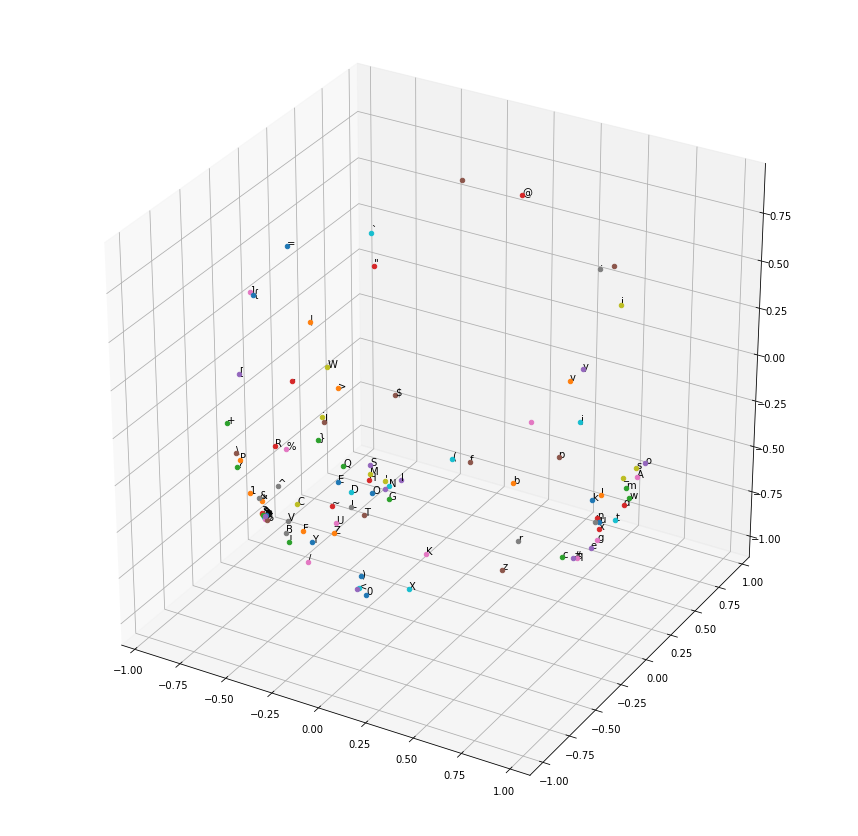

In [98]:
from mpl_toolkits.mplot3d import Axes3D
plt = pylab.figure(figsize=(15,15))
ax = plt.add_subplot(111, projection='3d')
char_labels = [int_to_char(i) for i in range(1, len(final_embeddings))]
for i, label in enumerate(char_labels):
    x, y, z = final_embeddings[i, :]
    ax.scatter(x,y,z)
    ax.text(x,y,z,  label, size=10, zorder=1, color='k') 

I don't know whether this embedding is actually capturing any useful information!

In [100]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

In [ ]:
plot()

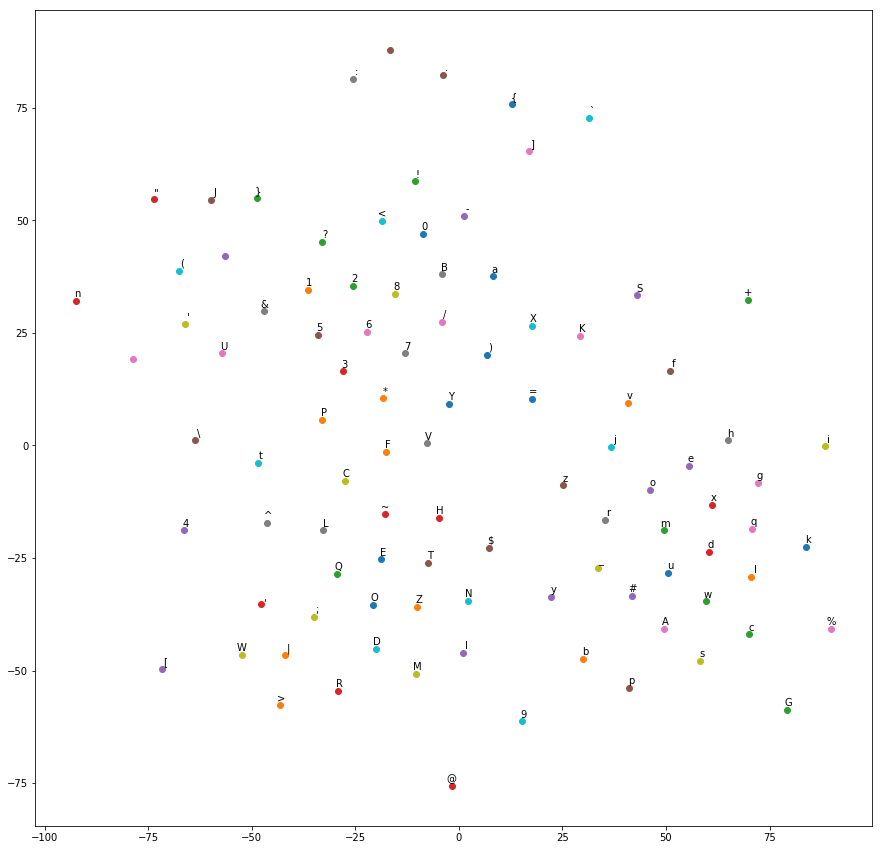

In [101]:
words = [int_to_char(i) for i in range(1, len(final_embeddings))]
plot(two_d_embeddings, words)